In [2]:
#! pip uninstall opencv-contrib-python -y 
#!pip install opencv-contrib-python
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

Uninstalling opencv-contrib-python-3.4.11.45:
  Successfully uninstalled opencv-contrib-python-3.4.11.45


Exception:
Traceback (most recent call last):
  File "D:\Anaconda3\lib\shutil.py", line 389, in _rmtree_unsafe
    os.unlink(fullname)
PermissionError: [WinError 5] Access is denied: 'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-uninstall-109r_xlf\\users\\hp\\appdata\\roaming\\python\\python37\\site-packages\\cv2\\cv2.cp37-win_amd64.pyd'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 143, in main
    status = self.run(options, args)
  File "D:\Anaconda3\lib\site-packages\pip\_internal\commands\uninstall.py", line 78, in run
    uninstall_pathset.commit()
  File "D:\Anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 275, in commit
    self.save_dir.cleanup()
  File "D:\Anaconda3\lib\site-packages\pip\_internal\utils\temp_dir.py", line 81, in cleanup
    rmtree(self.path)
  File "D:\Anaconda3\lib\site-packages\pip\_vendor\retrying.py", l

  Using cached https://files.pythonhosted.org/packages/6e/a3/6e2769f9c3ed35fc8fb70dc14d483d35ce789380442eee9b49fc411129f0/opencv_contrib_python-4.5.3.56-cp37-cp37m-win_amd64.whl


In [3]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM_objectDataset(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm


def findSVM_flowerPhotos(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions_objectDataset(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["accordion", "dollar_bill", "motorbike", "Soccer_Ball"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def plotConfusions_flowerPhotos(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulip"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    
def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

In [4]:
def trainModel_objectDataset(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 4
    image_count = len(images)

    for img_path in images:
        if("accordion" in img_path):
            class_index = 0
        elif("dollar_bill" in img_path):
            class_index = 1
        elif("motorbike" in img_path):
            class_index = 2
        else:
            class_index = 3

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM_objectDataset(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features


def trainModel_flowerPhotos(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 5
    image_count = len(images)

    for img_path in images:
        if("daisy" in img_path):
            class_index = 0
        elif( "dandelion" in img_path):
            class_index = 1
        elif("roses" in img_path):
            class_index = 2
        elif("sunflowers" in img_path):
            class_index = 3
        else:
            class_index = 4

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM_flowerPhotos(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [5]:
def testModel_objectDataset(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "accordion", 
        "1": "dollar_bill", 
        "2": "motorbike", 
        "3": "Soccer_Ball"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("accordion" in img_path):
                true.append("accordion")
            elif("dollar_bill" in img_path):
                true.append("dollar_bill")
            elif("motorbike" in img_path):
                true.append("motorbike")
            else:
                true.append("Soccer_Ball")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions_objectDataset(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")
    
    
def testModel_flowerPhotos(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "daisy", 
        "1": "dandelion", 
        "2": "roses", 
        "3": "sunflowers",
        "4": "tulips"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("daisy" in img_path):
                true.append("daisy")
            elif("dandelion" in img_path):
                true.append("dandelion")
            elif("roses" in img_path):
                true.append("roses")
            elif("sunflowers" in img_path):
                true.append("sunflowers")
            else:
                true.append("tulips")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions_flowerPhotos(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


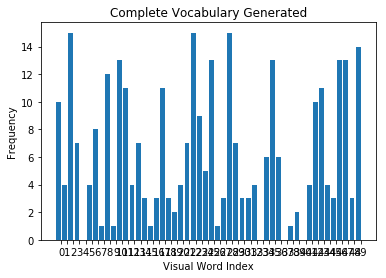

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 11.953747034072876 seconds ---


In [6]:
train_path = "C:\\Users\\HP\\Desktop\\Objects_Dataset_Images\\train"
test_path = "C:\\Users\\HP\\Desktop\\Objects_Dataset_Images\\test"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel_objectDataset(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[2 2 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 2]]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.5 0.5 0.  0. ]
 [nan nan nan nan]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]


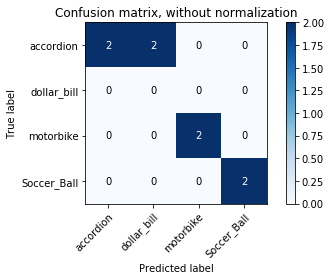

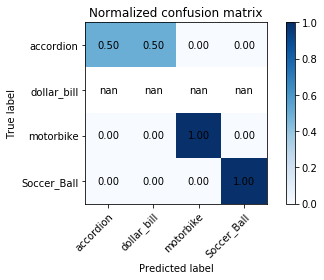

Confusion matrixes plotted.
accuracy score: 0.750
Accuracy calculated.
Execution done.
--- 0.8098587989807129 seconds ---


In [7]:
start_time = time.time()
testModel_objectDataset(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


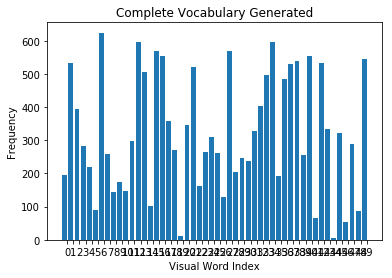

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
--- 1140.0884013175964 seconds ---


In [8]:
##splitted the dataset manually such that each category in test has 200 images
train_path = "C:\\Users\\HP\\Desktop\\flower_photos\\train"
test_path = "C:\\Users\\HP\\Desktop\\flower_photos\\test"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel_flowerPhotos(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
start_time = time.time()
testModel_flowerPhotos(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

Test images path detected.
